In [2]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
#         break
# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!git clone https://github.com/sunny1401/experiments_cv_nlp.git

Cloning into 'experiments_cv_nlp'...
remote: Enumerating objects: 693, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 693 (delta 23), reused 20 (delta 13), pack-reused 606
Receiving objects: 100% (693/693), 1.84 MiB | 3.69 MiB/s, done.
Resolving deltas: 100% (359/359), done.


In [4]:
!pip install python-gdcm pylibjpeg pylibjpeg-libjpeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 28.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 36.5 MB/s eta 0:00:0000:01:00:01


In [5]:
import sys
import cv2
import pydicom as dicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import numpy as np
import torch
import os

sys.path.append("experiments_cv_nlp")

In [6]:
train_images = "/kaggle/input/rsna-breast-cancer-detection/train_images"
test_images = "/kaggle/input/rsna-breast-cancer-detection/test_images"


annotation_train = "/kaggle/input/rsna-breast-cancer-detection/train.csv"
annotation_test= "/kaggle/input/rsna-breast-cancer-detection/test.csv"

In [44]:
import pydicom
import numpy as np
import torch
import os
from src.cv.pytorch.datasets.base_dataset import CustomDataset
from PIL import Image
import cv2


class BreastCancerDataset(CustomDataset):
    
    def __init__(
        self, 
        annotation_file: str, 
        img_dir: str, 
        composed_transforms=None,
        is_test: bool = False, 
    ):
        
        super().__init__(
            dataset_name = "rsna_breast_cancer_dataset",
            data_type="image",
            is_test=is_test,
            annotation_file=annotation_file,
            img_dir=img_dir,
            composed_transforms=composed_transforms
            
        )
        self.RESIZE_TO = (256, 256)
    
        
    def __parse_image(self, img: pydicom.dataset.FileDataset):
        
        image_array = img.pixel_array
        if img.PhotometricInterpretation == "MONOCHROME1":
            # normalize across pixel array to make difference prominent
            image_array = np.max(image_array) - image_array
        
        image_array = image_array - np.min(image_array)
        image_array = image_array / np.max(image_array)
        image_array = (image_array * 255).astype(np.uint8)
        image_array = cv2.resize(
                image_array, self.RESIZE_TO
            )
        return image_array
    
    def __len__(self):
        
        # while the images themselves are multiple -> 
        # either a patient will have cancer or won't.
        # information used for creating train and validation dataloader
        return self.dataset.image_labels.patient_id.nunique()
        
        
    def __getitem__(self, idx):
        
        # get idx to be returned as a list
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        required_columns = [
            "image_id", "patient_id", "laterality"
        ]
        
        if not self._is_test:
            required_columns.append("cancer")
        
        annotation_data = self.dataset.image_labels.loc[idx, required_columns]
        patient_id = str(int(annotation_data["patient_id"]))
        image_id = str(int(annotation_data["image_id"]))
        image_path = f"{os.path.join(self.dataset.img_directory, patient_id, image_id)}.dcm"
        image = self.__parse_image(pydicom.read_file(image_path))
        
        if not self._is_test:
            sample = dict(
                image=image, 
                label=annotation_data["cancer"], 
                lateral_view=annotation_data["laterality"]
            )

        else:
            sample = dict(
                image=image, 
                lateral_view=annotation_data["laterality"]
            )
        if self.transform:
            sample = self.transform(sample)

        
        if len(sample["image"].shape) == 2:
            sample["image"] = sample["image"][np.newaxis]


        if sample["image"].shape[0] == 1:
            # todo - do this correctly
            sample["image"] = np.reshape(sample["image"], (sample["image"].shape[1], sample["image"].shape[2], sample["image"].shape[0]))
            
        return sample


In [8]:
bcd_train = BreastCancerDataset(
    annotation_file="/kaggle/input/rsna-breast-cancer-detection/train.csv", 
    img_dir= train_images, 
)

In [45]:
bcd_test = BreastCancerDataset(
    annotation_file="/kaggle/input/rsna-breast-cancer-detection/test.csv", 
    img_dir= test_images, 
    is_test=True
)

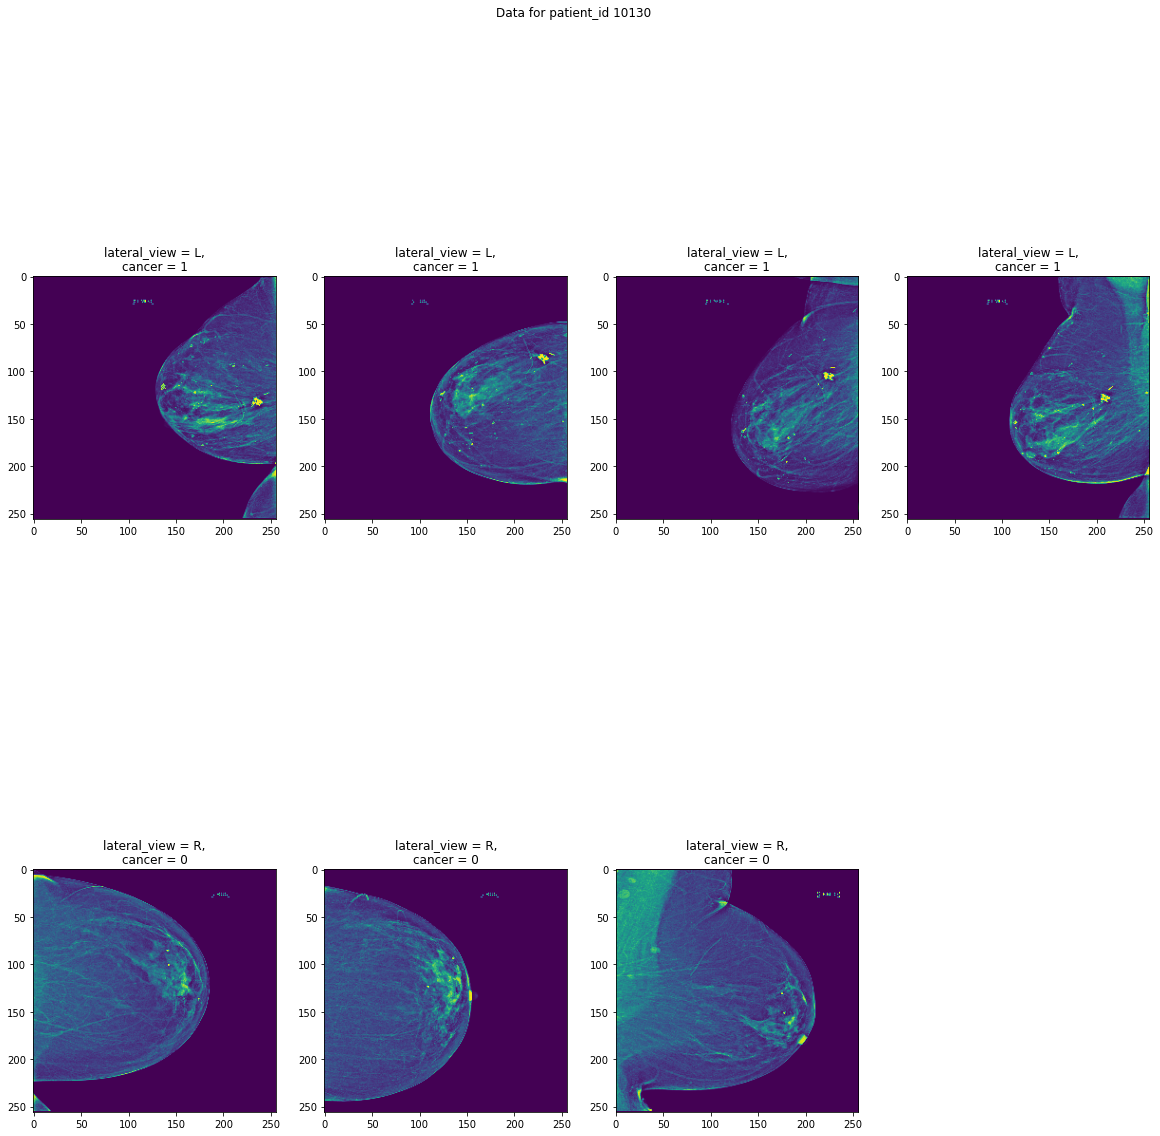

In [10]:
from src.cv.pytorch.datasets.breast_cancer_detection.utils import show_all_pictures_for_a_patient
show_all_pictures_for_a_patient(bcd_train, 87)

In [11]:
# Initial config for training
model_training_config = dict(
    learning_rate=0.02,
    batch_size=25,
    epochs=20,
    batch_norm_momentum=0.5
)
model_data_config = dict(
     dataset_size=len(bcd_train), train_data_pct=0.7, model_save_path="bcd_no_weight_resnet"
)

In [12]:
!nvidia-smi

Mon Feb 13 18:37:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:

RESNET_MODEL_ARCHITECTURES = dict(
    resnet18 = [
        ("BasicBlock", 1, 64, 2), 
        ("BasicBlock", 2, 128, 2), 
        ("BasicBlock", 2, 256, 2), 
        ("BasicBlock", 2, 512, 2)
    ],
    resnet34 = [
        ("BasicBlock", 1, 64, 3), 
        ("BasicBlock", 2, 128, 4), 
        ("BasicBlock", 2, 256, 6), 
        ("BasicBlock", 2, 512, 3)
    ],
    resnet50 = [
        ("BottleneckBlock", 1, 64, 3), 
        ("BottleneckBlock", 2, 128, 4), 
        ("BottleneckBlock", 2, 256, 6), 
        ("BottleneckBlock", 2, 512, 3)
    ],
    resnet101 = [
        ("BottleneckBlock", 1, 64, 3), 
        ("BottleneckBlock", 2, 128, 4), 
        ("BottleneckBlock", 2, 256, 23), 
        ("BottleneckBlock", 2, 512, 3)
    ],
    resnet152 = [
        ("BottleneckBlock", 1, 64, 3), 
        ("BottleneckBlock", 2, 128, 4), 
        ("BottleneckBlock", 2, 256, 36), 
        ("BottleneckBlock", 2, 512, 3)
    ],
)

In [14]:
model_initialization_params=dict(
    batch_norm_epsilon=1e-05, 
    batch_norm_momentum=model_training_config["batch_norm_momentum"],
    in_channels=1,
    num_classes=1,
    use_leaky_relu_in_resnet = True,
    alpha_leaky_relu = 0.01,
    resnet_stride_output_combination= RESNET_MODEL_ARCHITECTURES["resnet18"],
)

In [15]:
import torch.nn as nn
from typing import Optional, Dict, List, Union
import torch.nn.functional as F
from torch import nn


class ResnetBasicBlock(nn.Module):

    expansion: int = 1

    def __init__(
        self, 
        in_channels: int, 
        out_channels: int, 
        backpropagation_relu_details: Optional[Dict] = None, 
        check_for_downsample: bool = False,
        stride=1,
        use_leaky_relu: bool = False
    ) -> None:

        super(ResnetBasicBlock, self).__init__()
        backpropagation_relu_details = dict() if not backpropagation_relu_details else backpropagation_relu_details
        self._alpha_leaky_relu=backpropagation_relu_details.get("alpha_leaky_relu", 0.001) 
        self._cnn_batch_norm_flag=backpropagation_relu_details.get("cnn_batch_norm_flag", True)
        self._batch_norm_epsilon=backpropagation_relu_details.get("batch_norm_epsilon", 1e-05)
        self._batch_norm_momentum=backpropagation_relu_details.get("batch_norm_momentum", 0.1)
        self._linear_batch_norm_flag=backpropagation_relu_details.get("linear_batch_norm_flag", True)
        self._use_leaky_relu = use_leaky_relu


        if self._use_leaky_relu:
            relu = nn.LeakyReLU(negative_slope=self._alpha_leaky_relu)
        else:
            relu = nn.ReLU()

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=(3,3),
                stride=stride, 
                padding=1,
            ),
            nn.BatchNorm2d(
                num_features=out_channels, 
                eps=self._batch_norm_epsilon, 
                momentum=self._batch_norm_momentum, 
                affine=True, 
                track_running_stats=True
            ),
            relu
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=(3,3),
                padding=1,
            ),
            nn.BatchNorm2d(
                num_features=out_channels, 
                eps=self._batch_norm_epsilon, 
                momentum=self._batch_norm_momentum, 
                affine=True, 
                track_running_stats=True
            )
        )


        self.downsample = None

        if check_for_downsample and (stride != 1 or in_channels != self.expansion*out_channels):

            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=(1,1),
                    stride=stride,
                ),
                nn.BatchNorm2d(
                    num_features=out_channels, 
                    eps=self._batch_norm_epsilon, 
                    momentum=self._batch_norm_momentum, 
                    affine=True, 
                    track_running_stats=True
                )
            )
            
        
    def forward(self, img):
        identity = img.clone()

        img = self.conv1(img)
        img = self.conv2(img)

        if self.downsample:
            identity = self.downsample(identity)
        img += identity
        if self._use_leaky_relu:
            img = F.leaky_relu(img, negative_slope=self._alpha_leaky_relu)
        else:
            img = F.relu(img)
        return img


class ResnetBottleneckBlock(nn.Module):

    expansion = 4

    def __init__(
        self, 
        in_channels: int, 
        out_channels: int, 
        backpropagation_relu_details: Optional[Dict] = None, 
        check_for_downsample: bool = False,
        stride :int =1,
        use_leaky_relu: bool = False,
    ) -> None:

        super(ResnetBottleneckBlock, self).__init__()

        backpropagation_relu_details = dict() if not backpropagation_relu_details else backpropagation_relu_details
        self._alpha_leaky_relu=backpropagation_relu_details.get("alpha_leaky_relu", 0.001)
        self._cnn_batch_norm_flag=backpropagation_relu_details.get("cnn_batch_norm_flag", True)
        self._batch_norm_epsilon=backpropagation_relu_details.get("batch_norm_epsilon", 1e-05)
        self._batch_norm_momentum=backpropagation_relu_details.get("batch_norm_momentum", 0.1)
        self._linear_batch_norm_flag=backpropagation_relu_details.get("linear_batch_norm_flag", True)
        self._use_leaky_relu = use_leaky_relu
        
        self._use_leaky_relu = use_leaky_relu

        if self._use_leaky_relu:
            relu = nn.LeakyReLU(negative_slope=self._alpha_leaky_relu)
        else:
            relu = nn.ReLU()

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=(1,1),
            ),
            nn.BatchNorm2d(
                num_features=out_channels, 
                eps=self._batch_norm_epsilon, 
                momentum=self._batch_norm_momentum, 
                affine=True, 
                track_running_stats=True
            ),
            relu
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=(3,3),
                stride=stride,
                padding=1
            ),
            nn.BatchNorm2d(
                num_features=out_channels, 
                eps=self._batch_norm_epsilon, 
                momentum=self._batch_norm_momentum, 
                affine=True, 
                track_running_stats=True
            ),
            relu
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=(1,1),
            ),
            nn.BatchNorm2d(
                num_features=out_channels, 
                eps=self._batch_norm_epsilon, 
                momentum=self._batch_norm_momentum, 
                affine=True, 
                track_running_stats=True
            ),
            relu
        )

        self.downsample = None

        if check_for_downsample and (stride != 1 or in_channels != self.expansion*out_channels):
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=(1,1),
                    stride=stride,
                ),
                nn.BatchNorm2d(
                    num_features=out_channels, 
                    eps=self._batch_norm_epsilon, 
                    momentum=self._batch_norm_momentum, 
                    affine=True, 
                    track_running_stats=True
                )
            )

    def forward(self, img):
        identity = img.clone()

        img = self.conv1(img)
        img = self.conv2(img)
        
        if self.downsample:
            identity = self.downsample(identity)
        img += identity
        if self._use_leaky_relu:
            img = F.leaky_relu(img, negative_slope=self._alpha_leaky_relu)
        else:
            img = F.relu(img)
        return img


class VanillaResnet(nn.Module):

    def __init__(
        self, 
        device: str,
        in_channels: int, 
        num_classes: int, 
        resnet_stride_output_combination: List,
        alpha_leaky_relu: float=0.001, 
        batch_norm_epsilon: float = 1e-05,
        batch_norm_momentum: float = 0.1,
        cnn_batch_norm_flag: bool = True,
        linear_batch_norm_flag: bool = True,
        use_leaky_relu_in_resnet: bool = False,
        dropout_threshold: Optional[Union[float, List[float]]] = 0.01,
        num_linear_layers: int = 1, 
        output_channels: Optional[List[int]] = None,
        add_dropout_to_linear_layers: bool = True,
    ):

        super(VanillaResnet, self).__init__()

        # TODO - add dropout support within resnet
        self._backpropagation_relu_dict = dict(
            alpha_leaky_relu=alpha_leaky_relu,
            batch_norm_epsilon=batch_norm_epsilon,
            batch_norm_momentum=batch_norm_momentum,
            cnn_batch_norm_flag=cnn_batch_norm_flag,
            linear_batch_norm_flag=linear_batch_norm_flag
        )
        self._device = device
        self._basic_block_count = 1
        self._bottleneck_block_count = 1
        self._required_input_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=self._required_input_channels,
                kernel_size=(7,7),
                stride=2,
                padding=3,
            ),
            nn.BatchNorm2d(
                num_features=self._required_input_channels,
                eps=batch_norm_epsilon, 
                momentum=batch_norm_momentum, 
                affine=True, 
                track_running_stats=True
            ),
            nn.MaxPool2d(
                kernel_size=(3,3),
                stride=2,
                padding=1
            )

        )
        self._num_classes = num_classes
        self._resnet_block = []
        for (block_type, stride, output, num_layers) in resnet_stride_output_combination:

            if block_type == "BasicBlock":
                self._basic_block_count += 1
                self.add_basic_block(
                    out_channels=output, 
                    stride=stride,
                    use_leaky_relu=use_leaky_relu_in_resnet,
                    num_layers = num_layers
                )  

            elif block_type == "BottleneckBlock":
                self._bottleneck_block_count += 1
                self.add_bottleneck_block(
                    out_channels=output,
                    stride=stride,
                    use_leaky_relu=use_leaky_relu_in_resnet,
                    num_layers = num_layers
                )

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))

        if num_linear_layers > 1:

            if output_channels != num_linear_layers - 1:

                raise ValueError(
                    "The final layer of the resnet is a fully connected network with "
                    f"output neurons = {self._num_classes}. "
                    "For other layers please provide relevant outputs"
                )
        if add_dropout_to_linear_layers:
            if isinstance(dropout_threshold, List):
                if not len(dropout_threshold) == num_linear_layers - 1:

                    raise ValueError("Please provide dropout for all layers save last")
            elif num_linear_layers > 1:
                dropout_threshold = [dropout_threshold] * (num_linear_layers - 1)
            else:
                dropout_threshold = [dropout_threshold]

        for i in range(num_linear_layers - 1):

            network_layers = []
            network_layers.append(
                nn.Linear(
                    in_features=self._required_input_channels, 
                    out_features=output_channels[i], 
                    bias=True
                )
            )
            network_layers.append(
                nn.BatchNorm2d(
                    num_features=output_channels[i], 
                    eps=batch_norm_epsilon, 
                    momentum=batch_norm_momentum, 
                    affine=True, 
                    track_running_stats=True
                )
            )
            network_layers.append(nn.ReLU())
            if add_dropout_to_linear_layers:
                network_layers.append(
                    nn.Dropout(dropout_threshold[i])
                )

            linear = nn.Sequential(*network_layers)
            self._required_input_channels = output_channels[i]

            setattr(self, f"linear_layer_{i}", linear)
            self._resnet_block.append(("linear", linear))
        
        self.final_layer = nn.Linear(
                in_features=self._required_input_channels, 
                out_features=self._num_classes, 
                bias=True
            )

   
    def add_basic_block(
        self, 
        out_channels: int, 
        num_layers: int, 
        stride: int, 
        use_leaky_relu: bool = True
    ):
        in_channels = self._required_input_channels
        check_for_downsample = False
        for i in range(num_layers):
            if i == 0:
                check_for_downsample = True

            basic_block = ResnetBasicBlock(
                check_for_downsample=check_for_downsample,
                in_channels=in_channels,
                out_channels=out_channels, 
                stride=stride,
                use_leaky_relu=use_leaky_relu,
                backpropagation_relu_details=self._backpropagation_relu_dict
            ).to(self._device)
            setattr(self, f"BasicBlock_conv{self._basic_block_count}x_{i+1}", basic_block)
            self._resnet_block.append(("BBlock", basic_block))
            in_channels = out_channels * ResnetBasicBlock.expansion
        self._required_input_channels = out_channels

    def add_bottleneck_block(
        self, 
        out_channels: int, 
        num_layers: int, 
        stride: int, 
        use_leaky_relu: bool = True
    ):
        in_channels = self._required_input_channels
        check_for_downsample = False
        for i in range(num_layers):
            if i == 0:
                check_for_downsample = True
            bottleneck_block = ResnetBottleneckBlock(
                check_for_downsample=check_for_downsample,
                in_channels=in_channels,
                out_channels=out_channels, 
                stride=stride,
                use_leaky_relu=use_leaky_relu,
                backpropagation_relu_details=self._backpropagation_relu_dict
            ).to(self._device)
            setattr(self, f"BottleneckBlock_conv{self._bottleneck_block_count}x_{i+1}", bottleneck_block)
            self._resnet_block.append(("BBlock", bottleneck_block))
            in_channels = out_channels * ResnetBasicBlock.expansion

        self._required_input_channels = out_channels
    
    def forward(self, x):
        x = self.conv1(x)
        first_linear_occurence = False
        for layer_name, layer in self._resnet_block:
            if not first_linear_occurence and layer_name == "linear":
                x = self.avg_pool(x)
                x = x.view(x.size(0), -1)
                first_linear_occurence = True

            x = layer(x)

        if not first_linear_occurence:
            x = self.avg_pool(x)
            x = x.view(x.size(0), -1)
            first_linear_occurence = True

        x = self.final_layer(x)
        return x


In [17]:
from src.cv.model_pipelines.dl_base_pipeline import CNNTrainingPipeline
from typing import Dict, Optional, List
import numpy as np
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import sys


class BreastCancerTrainingPipeline(CNNTrainingPipeline):

    # Doctring generated by chatGPT
    """
    A pipeline to train BreastCancerDetection model on a facial keypoint detection dataset.
    Parameters:
        dataset (Dataset): The dataset to be used for training and validation.
        model_training_config (Dict): A dictionary containing the training configuration such as number of epochs, batch size etc.
        model_data_config (Dict): A dictionary containing the data configuration such as data preprocessing options.
        model_initialization_params (Dict): A dictionary containing the parameters to initialize the model.
        load_model_from_path (str, optional): The path to the checkpoint file containing a pre-trained model to be loaded.

    Methods:
        initialize_optimization_parameters(lr: float) -> Dict: Initializes the optimizer and criterion to be used for training.
        _initialize_model(device: str, model_params: Dict) -> torch.nn.Module: Initializes the model with the given parameters.
        _fit_model() -> float: Trains the model on the training data and returns the training loss.
        _validate_model() -> float: Validates the model on the validation data and returns the validation loss.
        get_predictions(test_dataloader: DataLoader, device: str) -> List: Makes predictions on the test data and returns a list of predictions.
    """

    def __init__(self, 
        dataset: Dataset, 
        model_training_config: Dict, 
        model_data_config: Dict, 
        model_initialization_params: Dict,
        load_model_from_path: Optional[str] = None
    ):
        self._min_validation_loss = sys.maxsize
        super().__init__(
                dataset=dataset, 
                model_training_config=model_training_config, 
                model_data_config=model_data_config, 
                model_initialization_params=model_initialization_params,
                load_model_from_path=load_model_from_path
            )
        

    def initialize_optimization_parameters(self, lr=0.0005, weights = None) -> Dict:
        criterion = nn.BCEWithLogitsLoss(weights)
        optimizer = optim.Adam(
            self.model.parameters(), lr=self.model_training_config.learning_rate
        )
        
        return optimizer, criterion

    def _initialize_model(self, device, model_params):

        other_required_keys = dict(
            dropout_threshold=0.09,
            num_linear_layers=1,
            output_channels=None,
            add_dropout_to_linear_layers=True,
            device=self.model_training_config.device
        
        )
        for key, value in other_required_keys.items():
            if key not in model_params:
                model_params[key] = value

        model = VanillaResnet(**model_params).to(device)
        return model

    def _generate_train_validation_indices(self, train_on_full_dataset: bool = False):
        columns_required = ["image_id", "patient_id", "laterality", "cancer"]
        df = self.dataset.dataset.image_labels[columns_required]
        if not train_on_full_dataset and self.model_data_config.train_data_pct < 1:
            test_pct = 1 - self.model_data_config.train_data_pct

            df["patient_id"] = df.apply(
                lambda row: f"{row['patient_id']}_{row['laterality']}", axis=1).drop(columns=["laterality"])

            num_cancer_val_ids = round(df[df.cancer == 1]["patient_id"].nunique() * test_pct)
            num_ncancer_val_ids = round(df[df.cancer == 0]["patient_id"].nunique() * test_pct)
            cancer_val_ids = list(np.random.choice(df[df.cancer == 1]["patient_id"].unique(), num_cancer_val_ids))
            num_ncancer_val_ids = list(np.random.choice(df[df.cancer == 0]["patient_id"].unique(), num_ncancer_val_ids))

            val_ids = cancer_val_ids + num_ncancer_val_ids
            train_ids = [patient_id for patient_id in df.patient_id.unique() if patient_id not in val_ids]
            val_indices = df[df.patient_id.isin(val_ids)].index
            train_indices = df[df.patient_id.isin(train_ids)].index

        else:
            train_indices = df.index.tolist()
            val_indices = None

        
        if len(train_indices) > 750:
            train_indices = train_indices[: 750]

        if len(val_indices) > 300:
            val_indices = val_indices[: 300]
        return train_indices, val_indices

    def _fit_model(self):
        self.model.train()
        batch_training_loss: float = 0

        for idx, data in enumerate(self._train_dataloader):
            image = data["image"]
            label = data["label"]
            # convert variables to floats for regression loss
            label = label.type(torch.FloatTensor)
            image = image.type(torch.FloatTensor)
    #         # inp is shape (N, C, H, W)
            image = image.reshape(image.shape[0], image.shape[-1], image.shape[1], image.shape[2])
            image = image.to(self.model_training_config.device)
            label = label.to(self.model_training_config.device)
            self.optimizer.zero_grad()
            outputs = self.model(image)
            loss = self.criterion(
                outputs, 
                label.reshape(label.shape[0], 1)
            )

            batch_training_loss += loss.item()
            loss.backward()
            self.optimizer.step()

        train_loss = batch_training_loss/ (idx +1)
        return train_loss

    def _validate_model(self):
        batch_validation_loss: float = 0
        self.model.eval()
        with torch.no_grad():

            for idx, data in enumerate(self._validation_dataloader):
                image = data["image"]
                label = data["label"]
                # convert variables to floats for regression loss
                label = label.type(torch.FloatTensor)
                image = image.type(torch.FloatTensor)
                image = image.reshape(image.shape[0], image.shape[-1], image.shape[1], image.shape[2])
                image = image.to(self.model_training_config.device)
                label = label.to(self.model_training_config.device)
                outputs = self.model(image)
                loss = self.criterion(
                    outputs, 
                    label.reshape(label.shape[0], 1)
                )
                batch_validation_loss += loss.item()

        validation_loss = batch_validation_loss/idx + 1
        if self._min_validation_loss > validation_loss:
            self._min_validation_loss = validation_loss
            self._final_trained_model = self.model
        return validation_loss

    def get_predictions(self, test_dataloader: List) -> List:

        model = self.best_model
        model.eval()

        output_keyp = []
        for data in test_dataloader:
            image = data.type(torch.FloatTensor)
            image = image.type(torch.FloatTensor)
            image = image.reshape(image.shape[0], image.shape[-1], image.shape[1], image.shape[2])
            image = image.to(self.model_training_config.device)
            outputs = model(image)
            if self.model_training_config.device == "cuda":
                outputs = outputs.cpu().data.numpy()
            output_keyp.append(outputs)

        return [preds.cpu().detach().numpy() for batch in output_keyp for preds in batch]

    def generate_test_dataloader_from_dataset(self, dataset: Dataset) -> List:

        dataloader = []
        index = 0
        dataset_finished = False
        current_end = self.model_training_config.batch_size
        while(current_end <= len(dataset)):
            dataloader.append(torch.from_numpy(np.array(
                [dataset[j]["image"] for j in range(index, current_end)]
            )))
            if dataset_finished:
                break
            index = current_end
            current_end += self.model_training_config.batch_size
            if current_end > len(dataset):
                current_end = len(dataset)
                dataset_finished = True

        return dataloader

In [18]:
bcd_pipeline = BreastCancerTrainingPipeline(
    dataset=bcd_train,
    model_data_config=model_data_config,
    model_initialization_params=model_initialization_params,
    model_training_config=model_training_config
)

In [19]:
bcd_pipeline.model

VanillaResnet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (BasicBlock_conv2x_1): ResnetBasicBlock(
    (conv1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
    )
  )
  (BasicBlock_conv2x_2): ResnetBasicBlock(
    (conv1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.5, affine=True, track_run

In [20]:
bcd_pipeline.train()

  0%|          | 0/20 [00:00<?, ?it/s]

root - INFO - Train Loss for epoch 0: 0.2572 - 13-Feb-23 18:51:13
root - INFO - Validation Loss for epoch 0: 1.1650 - 13-Feb-23 18:55:38


  5%|▌         | 1/20 [16:14<5:08:39, 974.71s/it]

root - INFO - Train Loss for epoch 1: 0.1310 - 13-Feb-23 19:06:05
root - INFO - Validation Loss for epoch 1: 1.1494 - 13-Feb-23 19:10:00


 10%|█         | 2/20 [30:36<4:32:32, 908.45s/it]

root - INFO - Train Loss for epoch 2: 0.1203 - 13-Feb-23 19:20:17
root - INFO - Validation Loss for epoch 2: 1.1485 - 13-Feb-23 19:24:11


 15%|█▌        | 3/20 [44:47<4:09:58, 882.25s/it]

root - INFO - Train Loss for epoch 3: 0.1462 - 13-Feb-23 19:34:32
root - INFO - Validation Loss for epoch 3: 1.2168 - 13-Feb-23 19:38:31


 20%|██        | 4/20 [59:07<3:52:54, 873.43s/it]

root - INFO - Train Loss for epoch 4: 0.1267 - 13-Feb-23 19:48:54
root - INFO - Validation Loss for epoch 4: 1.1498 - 13-Feb-23 19:52:51


 25%|██▌       | 5/20 [1:13:27<3:37:06, 868.46s/it]

root - INFO - Train Loss for epoch 5: 0.1429 - 13-Feb-23 20:03:09
root - INFO - Validation Loss for epoch 5: 1.1477 - 13-Feb-23 20:07:03


 30%|███       | 6/20 [1:27:39<3:21:19, 862.79s/it]

root - INFO - Train Loss for epoch 6: 0.1335 - 13-Feb-23 20:17:32
root - INFO - Validation Loss for epoch 6: 1.1615 - 13-Feb-23 20:21:34


 35%|███▌      | 7/20 [1:42:10<3:07:32, 865.58s/it]

root - INFO - Train Loss for epoch 7: 0.1429 - 13-Feb-23 20:31:59
root - INFO - Validation Loss for epoch 7: 1.1629 - 13-Feb-23 20:35:51


 40%|████      | 8/20 [1:56:27<2:52:33, 862.78s/it]

root - INFO - Train Loss for epoch 8: 0.1260 - 13-Feb-23 20:46:07
root - INFO - Validation Loss for epoch 8: 1.1629 - 13-Feb-23 20:50:09


 45%|████▌     | 9/20 [2:10:46<2:37:56, 861.53s/it]

root - INFO - Train Loss for epoch 9: 0.1144 - 13-Feb-23 21:00:34
root - INFO - Validation Loss for epoch 9: 1.1552 - 13-Feb-23 21:04:30


 50%|█████     | 10/20 [2:25:06<2:23:32, 861.25s/it]

root - INFO - Train Loss for epoch 10: 0.1208 - 13-Feb-23 21:14:51
root - INFO - Validation Loss for epoch 10: 1.1665 - 13-Feb-23 21:18:49


 55%|█████▌    | 11/20 [2:47:57<2:17:25, 916.13s/it]


KeyboardInterrupt: 

In [21]:
bcd_pipeline.best_model


VanillaResnet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (BasicBlock_conv2x_1): ResnetBasicBlock(
    (conv1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
    )
  )
  (BasicBlock_conv2x_2): ResnetBasicBlock(
    (conv1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.5, affine=True, track_run

In [23]:
def generate_test_dataloader_from_dataset(dataset: Dataset) -> List:

    dataloader = []
    index = 0
    dataset_finished = False
    current_end = bcd_pipeline.model_training_config.batch_size
    while(current_end <= len(dataset)):
        dataloader.append(torch.from_numpy(np.array(
            [dataset[j]["image"] for j in range(index, current_end)]
        )))
        if dataset_finished:
            break
        index = current_end
        current_end += bcd_pipeline.model_training_config.batch_size
        if current_end > len(dataset):
            current_end = len(dataset)
            dataset_finished = True

    return dataloader

In [24]:
test_dataloader = generate_test_dataloader_from_dataset(bcd_test)

In [25]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)

In [32]:
def get_predictions(data) -> List:

    model = bcd_pipeline.best_model
    model.eval()

        image = data.type(torch.FloatTensor)
        image = image.type(torch.FloatTensor)
        image = image.reshape(image.shape[0], image.shape[-1], image.shape[1], image.shape[2])
        image = image.to(bcd_pipeline.model_training_config.device)
        outputs = model(image)
        if bcd_pipeline.model_training_config.device == "cuda":
            outputs = sigmoid_v(outputs.cpu().data.numpy())
            
        output_keyp.append(outputs)

    return [preds.cpu().detach().numpy() for batch in output_keyp for preds in batch]

In [58]:
bcd_test[0]["image"].shape

(256, 256, 1)

2

In [68]:

image_inputs = []
outputs = []
for i in range(4):
    
    image = bcd_test[i]["image"]
    image = image.reshape(image.shape[-1], image.shape[0], image.shape[1])
    image_inputs.append(image)
    
image_inputs = np.array(image_inputs)

    

In [69]:
image_inputs.shape

(4, 1, 256, 256)

In [70]:
image_inputs = torch.from_numpy(image_inputs).type(torch.FloatTensor)

In [73]:
str(bcd_pipeline.model_training_config.device)

'cuda'

In [75]:
import math

In [76]:
image_inputs = image_inputs.to(bcd_pipeline.model_training_config.device)
output = model(image_inputs)
if str(bcd_pipeline.model_training_config.device) == "cuda":
    output = output.cpu().data.numpy()

outputs = sigmoid_v(output)


In [81]:
df = bcd_test.dataset.image_labels.prediction_id

In [84]:
import pandas as pd
df =pd.DataFrame(df)

In [86]:
df["cancer"] = outputs

In [87]:
df = df.groupby(["prediction_id"])["cancer"].mean()

In [97]:
df= df[["prediction_id", "cancer"]]
df.to_csv("submission.csv", index=False)

In [98]:
df

,prediction_id,cancer
0,10008_L,0.079668
1,10008_R,0.028687


In [91]:
outputs

array([[0.08154741],
       [0.07778854],
       [0.01783157],
       [0.03954168]])

In [ ]:
import pandas as pd
train_df = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/train.csv")
test_df = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/test.csv")

In [ ]:
import numpy as np
random_seed = 0
np.random.seed(random_seed)

In [ ]:

dict_view_map = {view: i for i, view in enumerate(list(train_df.view.unique()))}
dict_laterality_map = {laterality: i for i, laterality in enumerate(list(train_df.laterality.unique()))}
train_df.view = train_df.view.apply(lambda d: dict_view_map[d])
train_df.laterality = train_df.laterality.apply(lambda d: dict_laterality_map[d])

In [ ]:
train_df["id"] = train_df.apply(lambda row: f'{row["patient_id"]}_{row["image_id"]}', axis=1)
train_df.set_index("id", drop=True, inplace=True)

In [ ]:
train_df.loc[train_df.age.isna(), "age"] = train_df.age.mean()

In [ ]:
def get_train_test_patient_ids(train_df, test_pct=0.3):
    
    cancer_patients = list(train_df[train_df.cancer == 1].patient_id.unique())
    non_cancer_patients = list(train_df[train_df.cancer == 0].patient_id.unique())
    
    non_cancer_train_p = int(
        np.floor(len(non_cancer_patients) * (1-test_pct)))
    non_cancer_test_p = len(non_cancer_patients) - non_cancer_train_p
    
    train_ncancer_patients = list(np.random.choice(non_cancer_patients, size=non_cancer_train_p))
    test_ncancer_patients = list(set(non_cancer_patients) - set(train_ncancer_patients))
    
    cancer_train_p = int(np.floor(len(cancer_patients) * (1-test_pct)))
    cancer_test_p = len(cancer_patients) - cancer_train_p
    
    train_cancer_patients = list(np.random.choice(cancer_patients, size=cancer_train_p))
    test_cancer_patients = list(set(cancer_patients) - set(train_cancer_patients))
    
    train_patients = train_cancer_patients + train_ncancer_patients
    test_patients = test_cancer_patients + test_ncancer_patients
    
    val_df = train_df[train_df.patient_id.isin(list(test_patients))].reset_index(drop=True)
    train_df = train_df[train_df.patient_id.isin(list(train_patients))].reset_index(drop=True)
    return train_df, val_df
    

In [ ]:
trn_df, val_df = get_train_test_patient_ids(train_df)

In [ ]:
columns_to_remove = [column for column in train_df.columns if (column not in  {"cancer", "id"} and column not in test_df.columns)]
columns_to_remove += ["site_id", "patient_id", "image_id"]
trn_df.drop(columns=columns_to_remove, inplace=True)
val_df.drop(columns=columns_to_remove, inplace=True)

In [ ]:
y_train = trn_df.pop("cancer")
x_train = trn_df

y_val = val_df.pop("cancer")
x_val = val_df

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [ ]:
model1 = LogisticRegression(
    verbose=True, 
    random_state=random_seed, 
    solver="newton-cg",
    class_weight="balanced",
    penalty="l2",
    C=0.5
)

model1 = model1.fit(x_train, y_train)
preds = model1.predict(x_train)
print("Model inherent f1-score on training_data: ",f1_score(y_train, preds))

print("Model inherent score on training_data: ", model1.score(x_train, y_train))

In [ ]:
ratio = train_df[train_df.cancer == 1].patient_id.nunique()/train_df.patient_id.nunique()

In [ ]:
train_df[train_df.cancer == 0].patient_id.nunique()*ratio